<center>
<img src="https://wherenext.esri.de/wp-content/uploads/2019/02/Logo_CH_DE_Esri-800x130.png"/>
<h1> EsriKon 2020: Raster Analytics - Simple Change Detection auf Sentinel 2 Daten</h1>
<br><br>

## Schritt 1: Notwendige Bibliotheken importieren & mit GIS Platform verbinden

In [43]:
from arcgis.gis import GIS
from arcgis.raster.functions import clip, apply, remap, colormap, band_arithmetic, stretch
from arcgis.features import GeoAccessor
from arcgis.geometry.filters import intersects

from bokeh.models import Range1d, NumeralTickFormatter
from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import row

from IPython.display import clear_output, HTML, Image
from math import fsum
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
output_notebook()

Loading BokehJS ...

### Mit GIS Plattform(en) verbinden

In [ ]:
gis = GIS("home") # Lokaler Enterprise Account verbindet sich automatisch

In [ ]:
# agol_gis verbindet sich mit ArcGIS Online um geschützte Inhalte wie Sentinel zu nutzen

credentials= input("Bitte AGOL Benutzer eingeben: ")
agol_gis = GIS (None,username= credentials,set_active=False) 

print('Sind sind erfolgreich bei ArcGIS Online angemeldet als: ' + agol_gis.properties.user.username)

## Schritt 2: Daten auswählen & vorbereiten

### Sentinel Dienst auswählen

In [4]:
# Item Added From Toolbar
# Title: Sentinel-2 Views | Type: Image Service | Owner: esri
seninel2_item = agol_gis.content.get("fd61b9e0c69c4e14bebd50a9a968348c")
seninel2_layer = seninel2_item.layers[0]

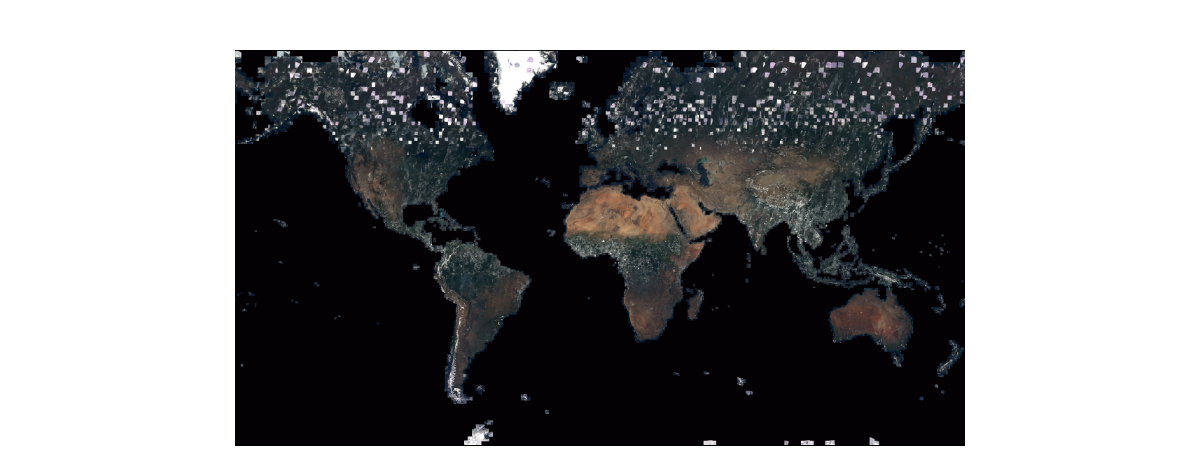

In [5]:
seninel2_layer

### Gebiet von Interesse auswählen

##### Landkreise DE

<Item title:"Germany Kreise Boundaries 2017" type:Feature Layer Collection owner:esri_livingatlas>
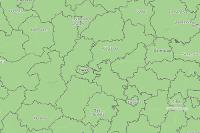

In [6]:
# Item Added From Toolbar
# Title: Germany Kreise Boundaries 2017 | Type: Feature Service | Owner: esri_livingatlas
item = gis.content.get("e4c2d3a250e8466db183eb652138d937")
item

### Was ist Pandas?

<center>
<img src="https://demoportal.esri.de/bilder/esrikon2020/pandas.gif"/>
</center>

<img style="position: relative;left:33%;float:left" src="https://miro.medium.com/proxy/1*93CVLqnQESmvfOhzvYUgQw.png" width=200><img style="position: relative;left:38%;float:left" src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/ed/Pandas_logo.svg/1200px-Pandas_logo.svg.png" width=200>
<br><br><br><br><br><br>
- Schnelle, flexible und aussagekräftige Datenstrukturen, welche die Arbeit mit relationalen Daten sowohl einfach als auch intuitiv macht.
- Fühlt sich an wie Excel

### Spatially Enabled Data Fram erstellen

<center>
<img src="https://demoportal.esri.de/bilder/esrikon2020/pandas_globe.png" width="600">
</center>

In [7]:
item_sdf = pd.DataFrame.spatial.from_layer(item.layers[3])
item_sdf.head(5)

,OBJECTID,ID,NAME,AREA,TOTPOP_CY,Shape__Area,Shape__Length,SHAPE
0,1,01,Dresden,5086.338422,1260623,0.653377,6.623829,"{'rings': [[[13.92191, 51.6185300000001], [13...."
1,2,02,Görlitz,3466.841287,426615,0.446409,4.640944,"{'rings': [[[14.729518, 51.5794320000001], [14..."
2,3,03,Cottbus,3109.083392,295540,0.404447,5.004726,"{'rings': [[[14.50059, 52.00809], [14.50146000..."
3,4,04,Leipzig,6202.532368,1247671,0.800336,8.470956,"{'rings': [[[13.20196, 51.878], [13.2023600000..."
4,5,06,Halle (Saale),9372.988602,1298673,1.214950,10.636436,"{'rings': [[[12.1220900000001, 51.907490000000..."


### Projektion angleichen

In [8]:
item_sdf.spatial.project(seninel2_layer.properties.spatialReference.latestWkid)

True

In [9]:
item_sdf.head(5)

,OBJECTID,ID,NAME,AREA,TOTPOP_CY,Shape__Area,Shape__Length,SHAPE
0,1,01,Dresden,5086.338422,1260623,0.653377,6.623829,"{'rings': [[[1549779.9320697833, 6731442.51452..."
1,2,02,Görlitz,3466.841287,426615,0.446409,4.640944,"{'rings': [[[1639682.4433903575, 6724435.69217..."
2,3,03,Cottbus,3109.083392,295540,0.404447,5.004726,"{'rings': [[[1614198.2950020346, 6801588.36235..."
3,4,04,Leipzig,6202.532368,1247671,0.800336,8.470956,"{'rings': [[[1469635.464673166, 6778096.278414..."
4,5,06,Halle (Saale),9372.988602,1298673,1.214950,10.636436,"{'rings': [[[1349424.8861502446, 6783415.71289..."


### Feature auswählen

In [10]:
item_select = item_sdf.loc[item_sdf['NAME'] == 'Bonn']
item_select

,OBJECTID,ID,NAME,AREA,TOTPOP_CY,Shape__Area,Shape__Length,SHAPE
49,50,53,Bonn,3411.941157,1279882,0.433228,5.244078,"{'rings': [[[824150.5105032804, 6612210.222989..."


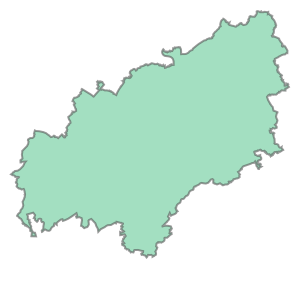

In [11]:
item_shape = item_select.iloc[0]['SHAPE']
item_shape

### Daten visualisieren

In [12]:
m = agol_gis.map('Bonn')
m.add_layer(seninel2_layer)
item_select.spatial.plot(map_widget=m)
m

MapView(layout=Layout(height='400px', width='100%'))

## Schritt 3: Sentinel auf Feature zuschneiden & Raster Funktionen anwenden 

### Sentinel zuschneiden und filtern (Zeit & Attribute)

In [13]:
sentinel_bonn = clip(seninel2_layer,item_shape)

In [14]:
sentinel_bonn_images = sentinel_bonn.filter_by(where="(category = 1) AND (cloudcover <= 0.05)",
                             time=[datetime(2020,2,1), datetime(2020,3,1)],
                             #time=[datetime(2018,2,8), datetime(2020,2,8)],
                             geometry=intersects(item_shape))

In [15]:
sentinel_bonn_images_sdf = sentinel_bonn_images.query(out_fields="objectid,acquisitiondate,cloudcover, tile_id", 
                    order_by_fields="acquisitiondate").sdf
sentinel_bonn_images_sdf

,objectid,acquisitiondate,cloudcover,tile_id,shape_Length,shape_Area,SHAPE
0,9481225,2020-02-07 10:46:42,0.0000,20200207T104641_32ULB_0,694211.343341,3.011886e+10,"{'rings': [[[860115.1345000006, 6526068.5669],..."
1,9481226,2020-02-07 10:46:43,0.0000,20200207T104643_31UGS_0,693270.082573,3.003724e+10,"{'rings': [[[829076.6787, 6686113.418700002], ..."
2,9481230,2020-02-07 10:46:56,0.0088,20200207T104655_32ULA_0,681159.590634,2.899708e+10,"{'rings': [[[862729.3440999985, 6370377.506200..."
3,9481231,2020-02-07 10:46:58,0.0072,20200207T104657_31UGR_0,680270.219659,2.892141e+10,"{'rings': [[[819632.1341999993, 6527849.603799..."


In [16]:
m = agol_gis.map('Bonn')
m.add_layer(sentinel_bonn_images)
m

MapView(layout=Layout(height='400px', width='100%'))

### Rasterfunktionen anwenden

In [17]:
bonn_sentinel_ndvi = band_arithmetic(sentinel_bonn_images,
                                     band_indexes= ('8 4'),
                                     method='(b8-b4)/(b8+b4)',
                                     astype='8u')

In [18]:
bonn_sentinel_ndvi_stretched = stretch(bonn_sentinel_ndvi,
                                       stretch_type='stddev',
                                       num_stddev=3,
                                       dra=True,
                                       astype='8u')

In [19]:
m.remove_layers(m.layers[0])
m.add_layer(bonn_sentinel_ndvi_stretched)

## Alternative: Raster Function Template anwenden & Zuschneiden

In [20]:
for function in seninel2_layer.properties.rasterFunctionInfos:
    print(function.name)

Natural Color with DRA
Agriculture with DRA
Bathymetric with DRA
Color Infrared with DRA
Short-wave Infrared with DRA
Geology with DRA
Natural Color
Agriculture
Bathymetric
Geology
Short-wave Infrared
Color Infrared
NDVI Colormap
NDMI Colorized
Normalized Burn Ratio
Normalized Difference Built-Up Index (NDBI)
NDVI Raw
NDVI - VRE only Raw
NDVI - with VRE Raw
NDWI Raw
NDWI - with VRE Raw
None


In [21]:
bonn_sentinel_ndvi_colormap = clip(apply(seninel2_layer,'NDVI Colormap'),item_shape).filter_by(where="(category = 1) AND (cloudcover <= 0.05)",
                             time=[datetime(2020,2,7), datetime(2020,2,8)],geometry=intersects(item_shape))

In [22]:
m = agol_gis.map('Bonn')
m.add_layer(bonn_sentinel_ndvi_colormap)
m

MapView(layout=Layout(height='400px', width='100%'))

## Schritt 4: Pixelwerte Abfragen und Analysieren

### Statistik und Histogramm berechnen

In [23]:
#Bei größeren Ausschnitten muss die Pixel Size angepasst werden, da der maximale Bildgrößen Export des Sentinel 2 Layer 4000 x 4000 Pixel beträgt.

statsHistDate1 = bonn_sentinel_ndvi.compute_stats_and_histograms(item_shape,pixel_size='35,35')

#### Funktion zum Hostogram Plotten

In [54]:
#####Function to plot based on group size and data (counts), returns bokeh histogram.######
def plotHistograms(counts, nGroups):
    #counts is a variable (topValUngrouped = statsHistold['histograms'][0]['counts']) statsHistold will change eveytime a new set of numbers is needed
    #nGroups is a number divisible by 256 of our choosing 
    
    #assert (256 % nGroups == 0), "Number of groups must be a divisor of 256" #This is making our custom error message: if the nGroups entered is not a divisor of 256 then display error string
    
    #Divied list up in nGroups sublists, taken from https://stackoverflow.com/questions/9671224/split-a-python-list-into-other-sublists-i-e-smaller-lists
    #chunks = [counts[x:x+int(256/nGroups)] for x in range(0, len(counts), int(256/nGroups))] 

    # Sum all items in each sublist and store these in a new list.
    #topValGrouped=[]
    #i=0
    #while i < len(chunks):
        #print (chunks[i])
        #topValGrouped.append(fsum(chunks[i]))
        #i+=1

    # Create names for each bar.
    start = -1.0
    groupIncrement = 2/nGroups
    xLabel = [] # creating empty list to input str from count plus each increment 
    while start < 1:
        xLabel.append(str(round(start, 2)) + " to " + str(round(start+groupIncrement, 2)))
        start+=groupIncrement
    
    #print(len(xLabel), groupIncrement, len(chunks))
    
    #Plotting, dynamic width depending on amount of groups.
    p = figure(title='NDVI distribution for chosen study area',plot_width=800, plot_height=400, x_range=xLabel) # title needs to be modified manually
    p.vbar(x=xLabel, width=0.5, bottom=0,
           top=counts, color="firebrick")
    p.yaxis.formatter=NumeralTickFormatter(format="0")
    p.xaxis.major_label_orientation = 1 # change label x orientation
    p.yaxis.axis_label = "Pixel Count"
    p.xaxis.axis_label_text_font_style = "bold"
    p.xaxis.axis_label =" NDVI raging from -1 to 1" # labeling axis manual modification 
    p.yaxis.axis_label_text_font_style = "bold" # styling 
    
    #If we have too many bars, remove labels on the x-axis:
    if nGroups > 32:
        p.xaxis.major_label_text_color = None
    
    return p

### Histogramm anzeigen

In [80]:
topValUngrouped = statsHistDate1['histograms'][0]['counts'] # this will change old and new depending on variable name
plotDate1 = plotHistograms(topValUngrouped, statsHistDate1['histograms'][0]['size'])
show(row(plotDate1))

### Pixelwerte in Klassen mappen und als Bild exportieren

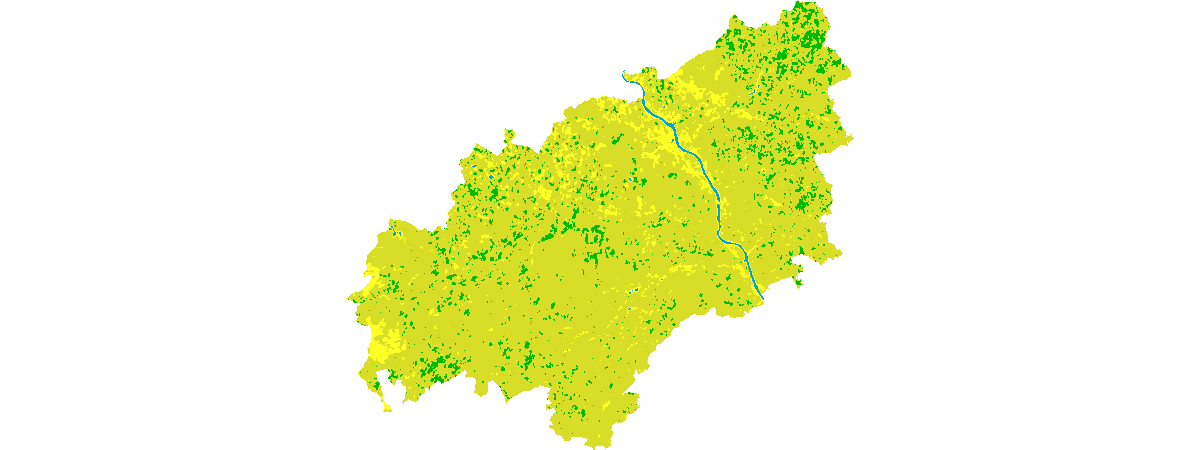

In [57]:
# CALCULATE AREA IN PERCENT AND REMAP TO NDVI CLASSES SECOND DATE 
#Reclassifying and colormapping to calculate area 
reclassVals=[1,2,3,4]
bonn_sentinel_ndvi_remap = colormap(remap(bonn_sentinel_ndvi, input_ranges=[-1,0.0,
                                              0.0,0.26,
                                              0.26,0.56,
                                              0.56,1],
                           output_values=reclassVals,
                           allow_unmatched=False), colormap=[[4,0, 187, 0],# Dichte Vegetation
                                                             [3, 216, 221, 40],# Leichte Vegetation
                                                             [2, 255, 255, 40],# Gebäude und nicht bewachsene Oberflächen
                                                             [1,4, 160, 224]],astype='U8')# Wasserkörper
                                                            # NOTE. we can get RGB combinations from http://colorizer.org/ if desired or anyother website 
#Extent anpassen
bonn_sentinel_ndvi_remap.extent.xmin = item_shape.extent[0]
bonn_sentinel_ndvi_remap.extent.xmax = item_shape.extent[2]
bonn_sentinel_ndvi_remap.extent.ymin = item_shape.extent[1]
bonn_sentinel_ndvi_remap.extent.ymax = item_shape.extent[3]

#Ergebnis als Bild ausgeben
img = Image(bonn_sentinel_ndvi_remap.export_image(bbox=bonn_sentinel_ndvi_remap.extent, size=[1200,450], f='image'))
img

### Flächenanteil der Kategorien berechnen

In [89]:
StatsHistDate1_remap = bonn_sentinel_ndvi_remap.compute_stats_and_histograms(item_shape,pixel_size='35,35')

In [91]:
histogram = StatsHistDate1_remap['histograms'][0]['counts'][1:]
numpix = np.sum(histogram)
sqmarea = numpix * 35 * 35

In [92]:
data = []
for j in histogram:
    data.append(j/numpix*sqmarea)
data

[149198875.0, 1525699525.0, 5230413125.0, 1550360000.0]

### Ergebnisse Plotten

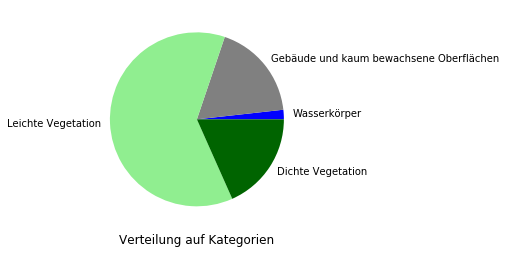

In [106]:
plt.title('Verteilung auf Kategorien', y=-0.1)
colors = ['blue', 'grey', 'lightgreen', 'darkgreen']
plt.pie(data, labels=['Wasserkörper','Gebäude und kaum bewachsene Oberflächen','Leichte Vegetation','Dichte Vegetation'], colors = colors);

## Schritt 5: Change Detection

### Daten für 2. Datum auswählen

In [64]:
bonn_sentinel_ndvi_old = clip(apply(seninel2_layer,'NDVI Raw'),item_shape).filter_by(where="(category = 1) AND (cloudcover <= 0.05)",
                             time=[datetime(2019,7,24), datetime(2019,7,25)],geometry=intersects(item_shape))

In [65]:
bonn_sentinel_ndvi_old_sdf = bonn_sentinel_ndvi_old.query(out_fields="objectid,acquisitiondate,cloudcover, tile_id", 
                    order_by_fields="acquisitiondate").sdf
bonn_sentinel_ndvi_old_sdf

,objectid,acquisitiondate,cloudcover,tile_id,shape_Length,shape_Area,SHAPE
0,7772310,2019-07-24 10:37:01,0.0003,20190724T103700_32ULB_0,562106.350846,1.804311e+10,"{'rings': [[[860115.1207999997, 6526069.355999..."
1,7772311,2019-07-24 10:37:02,0.0000,20190724T103702_31UGS_0,492201.246787,1.230479e+10,"{'rings': [[[829076.8117000014, 6686115.649899..."
2,7749638,2019-07-24 10:37:16,0.0000,20190724T103715_32ULA_0,639534.970435,2.505696e+10,"{'rings': [[[862729.3440999985, 6370377.508900..."
3,7476308,2019-07-24 10:37:17,0.0000,20190724T103717_31UGR_0,546556.288991,1.724841e+10,"{'rings': [[[819632.2256999984, 6527851.189999..."


### Vergleich visualisieren

In [66]:
###### Plot Histogram von Date 1 und Date 2 nebeneinander #######
statsHistDate2 = bonn_sentinel_ndvi_old.compute_stats_and_histograms(item_shape,pixel_size='35,35')
topValUngrouped = statsHistDate2['histograms'][0]['counts'] # this will change old and new depending on variable name
plotDate2 = plotHistograms(topValUngrouped, statsHistDate2['histograms'][0]['size'])
show(row(plotDate1,plotDate2))

In [67]:
# CALCULATE AREA IN PERCENT AND REMAP TO NDVI CLASSES SECOND DATE 
#Reclassifying and colormapping to calculate area 
reclassVals=[1,2,3,4]
bonn_sentinel_ndvi_remap_old = colormap(remap(bonn_sentinel_ndvi_old, input_ranges=[-1,0.0,
                                              0.0,0.26,
                                              0.26,0.56,
                                              0.56,1],
                           output_values=reclassVals,
                           allow_unmatched=False), colormap=[[4,0, 187, 0],# Dichte Vegetation
                                                             [3, 216, 221, 40],# Leichte Vegetation
                                                             [2, 255, 255, 40],# Gebäude und nicht bewachsene Oberflächen
                                                             [1,4, 160, 224]],astype='U8')# Wasserkörper
                                                            # NOTE. we can get RGB combinations from http://colorizer.org/ if desired or anyother website 
#Extent anpassen
bonn_sentinel_ndvi_remap_old.extent.xmin = item_shape.extent[0]
bonn_sentinel_ndvi_remap_old.extent.xmax = item_shape.extent[2]
bonn_sentinel_ndvi_remap_old.extent.ymin = item_shape.extent[1]
bonn_sentinel_ndvi_remap_old.extent.ymax = item_shape.extent[3]

#Ergebnis als Bild ausgeben
img2 = Image(bonn_sentinel_ndvi_remap_old.export_image(bbox=bonn_sentinel_ndvi_remap.extent, size=[1200,450], f='image'))

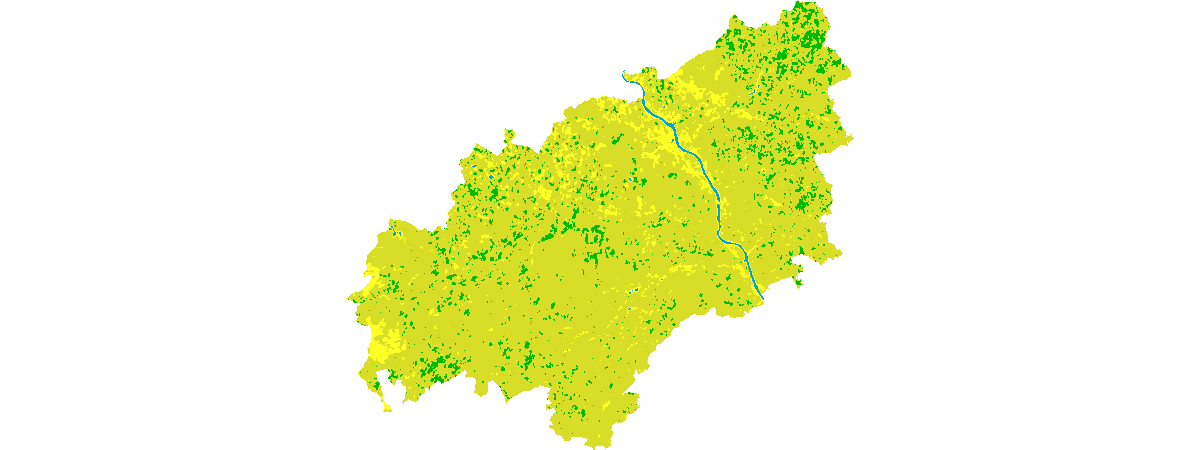

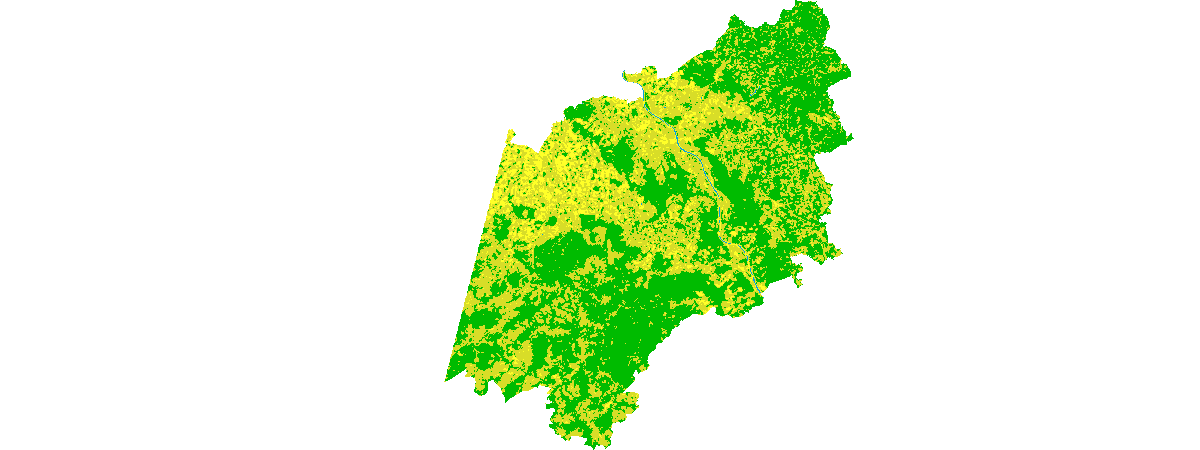

In [68]:
display(img, img2)

In [95]:
statsHistDate2_remap = bonn_sentinel_ndvi_remap_old.compute_stats_and_histograms(item_shape,pixel_size='35,35')

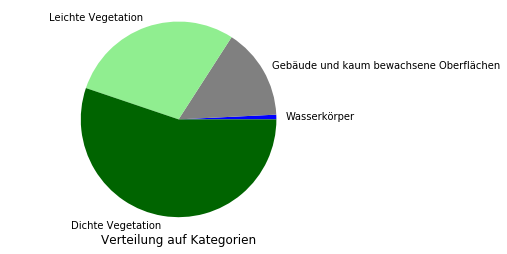

In [136]:
histogram2 = statsHistDate2_remap['histograms'][0]['counts'][1:]
data2 = []
for j in histogram2:
    data2.append(j/numpix*sqmarea)
plt.title('Verteilung auf Kategorien', y=-0.1)
colors = ['blue', 'grey', 'lightgreen', 'darkgreen']
plt.pie(data2, labels=['Wasserkörper','Gebäude und kaum bewachsene Oberflächen','Leichte Vegetation','Dichte Vegetation'], colors = colors);
plt.axis('equal');

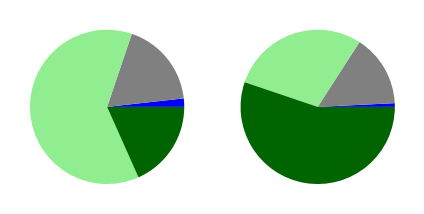

In [135]:
fig, ((ax1), (ax2)) = plt.subplots(nrows=1, ncols=2)
plt.subplot(ax1)
plt.pie(data, colors= colors);
plt.subplot(ax2)
plt.pie(data2, colors = colors);
plt.tight_layout()

### Karte und Pie Chart mit Change Detection Ergebnissen erstellen

In [142]:
# Unterschied zwischen den beiden Daten auf Pixelbasis mit Map Algebra berechnen
diff = bonn_sentinel_ndvi_remap-bonn_sentinel_ndvi_remap_old

In [143]:
#Reklassifizierung in 3 Kategorien (Loss, Stable, Gain)
reclassVals=[1,2,3]
remapdiff = colormap(remap(diff, input_ranges=[-3,0,# Vegetations Zunahme
                                               0,0,# Keine Veränderung
                                               1,3]# Vegetation Abnahme
                           ,output_values=reclassVals,
                           allow_unmatched=False), colormap=[[1,255, 5, 39],# loss 
                                                             [2,163, 163, 163],# No Change (Gray)
                                                             [3, 0, 174, 0]],astype='U8')# Gain
remaphistdiff= remapdiff.compute_stats_and_histograms(item_shape, pixel_size='35,35')

In [145]:
# Displa difference in NDVI from two dates reclassified as loss, gain and no change 
m =agol_gis.map('Bonn')
print('Difference in NDVI classified as no change (gray), loss (red), gain (green)')
m.add_layer(remapdiff)
m

Difference in NDVI classified as no change (gray), loss (red), gain (green)


MapView(layout=Layout(height='400px', width='100%'))

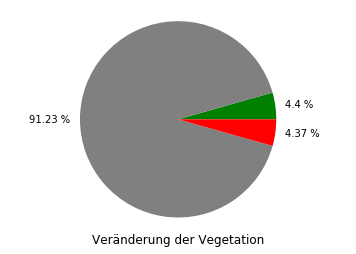

In [156]:
histogram3 = remaphistdiff['histograms'][0]['counts'][1:]
labels = []
for j in histogram3:
    labels.append(str(round(j/sum(histogram3)*100,2))+' %')
plt.title('Veränderung der Vegetation', y=-0.1)
colors2 = ['green', 'gray', 'red']
plt.pie(histogram3, labels=labels, colors = colors2);
plt.axis('equal');